In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Part I


Text(0.5, 1.0, 'Movie frame before removing black borders')

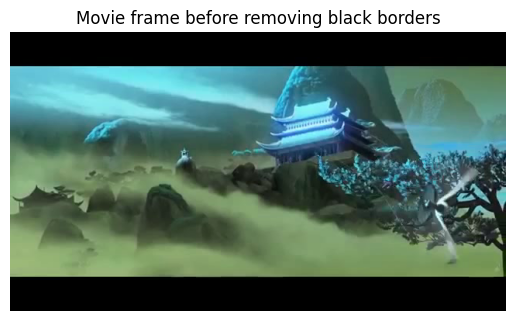

In [12]:
book_vid = cv.VideoCapture("book.mov")
ret, book_first_frame = book_vid.read()
book_img = cv.imread("cv_cover.jpg", cv.IMREAD_UNCHANGED)
book_img = cv.cvtColor(book_img, cv.COLOR_BGR2RGB)
vid = cv.VideoCapture("ar_source.mov")
success, vid_first_frame = vid.read()

plt.imshow(vid_first_frame)
plt.axis('off')
plt.title("Movie frame before removing black borders")

Text(0.5, 1.0, 'Movie frame after removing black borders')

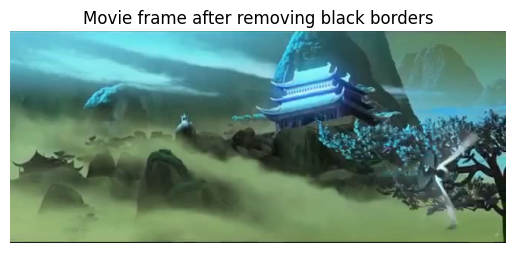

In [13]:
def remove_black_borders(frame, threshold=10):
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    # Create mask where pixels are > threshold (non-black)
    mask = gray > threshold

    coords = cv.findNonZero(mask.astype(np.uint8))
    if coords is not None:
        x, y, w, h = cv.boundingRect(coords)
        cropped = frame[y:y+h, x:x+w]
        return cropped
    else:
        # If everything is black, return original
        return frame

vid_first_frame = remove_black_borders(vid_first_frame)
plt.imshow(vid_first_frame)
plt.axis('off')
plt.title("Movie frame after removing black borders")

## Homagraphy Computation


In [ ]:
def homography_matrix(src_pts, dst_pts):
    src_pts = np.asarray(src_pts, dtype=float)
    dst_pts = np.asarray(dst_pts, dtype=float)

    if src_pts.shape[1] == 3:
        src_pts = src_pts[:, :2] / src_pts[:, 2:3]
    if dst_pts.shape[1] == 3:
        dst_pts = dst_pts[:, :2] / dst_pts[:, 2:3]
        
    src_pts = np.reshape(src_pts, (-1, 2))
    dst_pts = np.reshape(dst_pts, (-1, 2))

    A = []
    for (x, y), (u, v) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, u * x, u * y, u])
        A.append([0, 0, 0, -x, -y, -1, v * x, v * y, v])

    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    H /= H[-1, -1]

    # print("\nEstimated Homography Matrix:\n", H)
    return H


def compute_homography_ransac(src_pts, dst_pts, threshold=3.0, max_iters=2000):
    n = len(src_pts)
    best_inliers = []
    best_H = None
    src_pts = np.array(src_pts, dtype=float)
    dst_pts = np.array(dst_pts, dtype=float)

    for _ in range(max_iters):
        # Randomly pick 4 points
        idx = np.random.choice(n, 4, replace=False)
        try:
            H = homography_matrix(src_pts[idx], dst_pts[idx])
        except np.linalg.LinAlgError:
            continue

        # Compute reprojection errors
        src_h = np.hstack([src_pts, np.ones((n, 1))])
        proj_h = (H @ src_h.T).T
        proj = proj_h[:, :2] / proj_h[:, 2:3]
        errors = np.linalg.norm(proj - dst_pts, axis=1)
        inliers = np.where(errors < threshold)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

        # Early stop if we already have most points as inliers
        if len(best_inliers) > 0.9 * n:
            break

    # Recompute final H using all inliers
    if len(best_inliers) >= 4:
        best_H = homography_matrix(src_pts[best_inliers], dst_pts[best_inliers])

    return best_H


## Brute Force & KNN


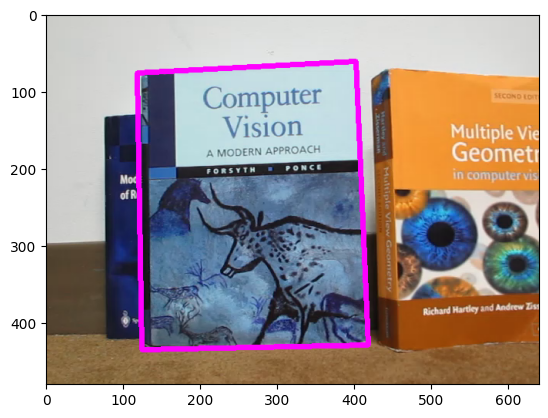

In [ ]:
def knn_brute_force(img1, img2):
    
    gray1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY) 
    gray2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY) 

    h1, w1 = img1.shape[:2]

    sift = cv.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    test_ratio = 0.75
    good_matches = []
    for m, n in matches:
        if m.distance < n.distance * test_ratio:
            good_matches.append(m)

    # print(f"Good matches found: {len(good_matches)}")

    sorted_matches = sorted(good_matches, key=lambda x: x.distance)

    nMatches = min(50, len(good_matches))
    draw_params = dict(
        matchColor=(255, 0, 0),
        singlePointColor=(255, 0, 0),
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    img_match = cv.drawMatches(img1, keypoints1, img2, keypoints2,
                               sorted_matches[:nMatches], None, **draw_params)

    # Extract point coordinates for homography
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in sorted_matches[:nMatches]])
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in sorted_matches[:nMatches]])

    if src_pts.shape[0] < 4:
        raise ValueError("Need at least 4 correspondences with matching shapes")

    H = compute_homography_ransac(src_pts, dst_pts)
    # print("Estimated Homography:\n", H)

    # H_cv, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC)
    # print("OpenCV H:\n", H_cv)

    #check = plot_homography_points(img1, img2, H, src_pts)
    corners_src = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners_dst = cv.perspectiveTransform(corners_src, H)
    # print("Corners Position: ", corners_dst)

    corner_img = img2.copy()
    corner_img = cv.polylines(corner_img, [np.int32(corners_dst)], True, (255,0, 255), 6)
    plt.imshow(corner_img)

    h2, w2 = img2.shape[:2]
    warped = cv.warpPerspective(img1, H, (w2, h2))
    mask = np.zeros((h2, w2), np.uint8)
    cv.fillPoly(mask, [np.int32(corners_dst)], (255,255,255))

    return H, img_match, warped, mask, corners_dst

H, img_match, warped, mask, corner_positions = knn_brute_force(book_img, book_first_frame)


Text(0.5, 1.0, 'Matching Correspondences')

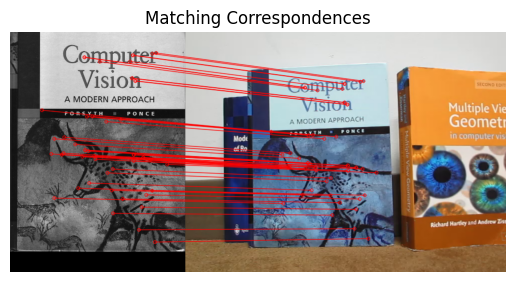

In [23]:
plt.imshow(img_match)
plt.axis('off')
plt.title("Matching Correspondences")

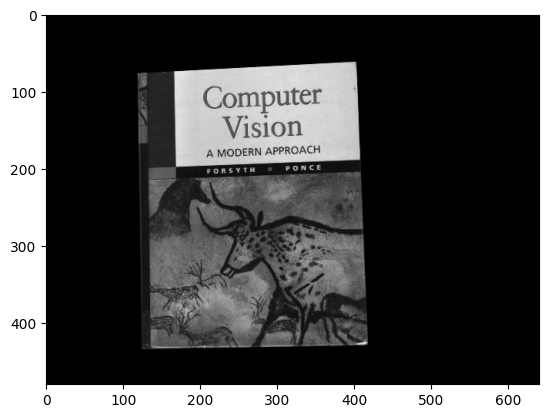

In [24]:
plt.imshow(warped)

## Center crop


Text(0.5, 1.0, 'Crpped Video Frame')

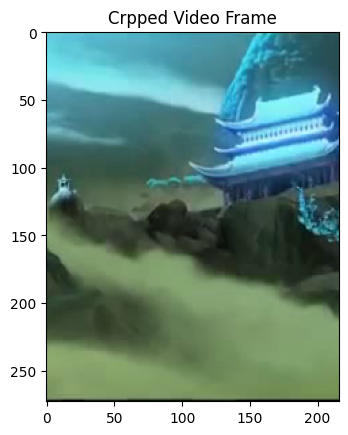

In [25]:
def crop_movie(vid, mask):
    h_vid, w_vid = vid.shape[:2]

    top_left = mask[0]
    bottom_left = mask [1]
    bottom_right = mask[2]
    top_right = mask[3]

    w_book = int(np.linalg.norm(top_right-top_left))
    h_book = int(np.linalg.norm(bottom_left-top_left))

    vid_aspect = w_vid / h_vid
    book_aspect = w_book / h_book

    if vid_aspect > book_aspect:
        new_w = int(h_vid * book_aspect)
        new_h = h_vid
    else: 
        new_w = w_vid
        new_h = int(w_vid / book_aspect)

    mid_h = (h_vid - new_h)  //2
    mid_w = (w_vid - new_w) //2

    crop_img = vid.copy()
    crop_img = crop_img[mid_h:mid_h + new_h, mid_w : mid_w + new_w]

    return crop_img

cropped_frame = crop_movie(vid_first_frame, corner_positions)
plt.imshow(cropped_frame)
plt.title("Crpped Video Frame")

## Overlaying 


Text(0.5, 1.0, 'Movie frame / Book overlay')

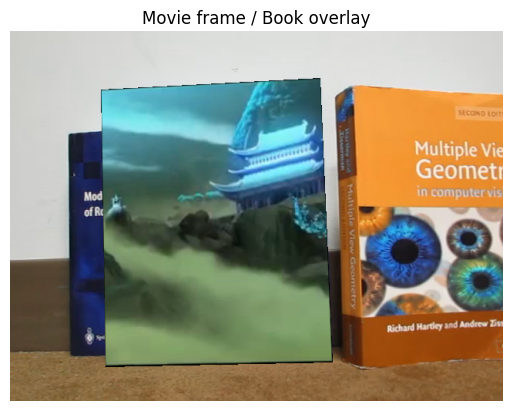

In [26]:
def overlay(vid_frame_cropped, book_frame, book_corners):
    
    h_vid , w_vid = vid_frame_cropped.shape[:2]
    src_corners = np.array([[0, 0],
                            [0, h_vid],
                            [w_vid, h_vid],
                            [w_vid, 0]])
    

    H = homography_matrix(src_corners, book_corners)
    # print("Estimated Homography:\n", H)

    # H_cv, _ = cv.findHomography(src_corners, book_corners, cv.RANSAC)
    # print("OpenCV H:\n", H_cv)

    warped = cv.warpPerspective(vid_frame_cropped, H, (book_frame.shape[1], book_frame.shape[0]))
    
    mask = np.zeros((book_frame.shape[0], book_frame.shape[1]), dtype=np.uint8)
    cv.fillConvexPoly(mask, book_corners.astype(int), 255)
    mask_inv = cv.bitwise_not(mask)

    # Combine warped video with original frame
    bg = cv.bitwise_and(book_frame, book_frame, mask=mask_inv)
    fg = cv.bitwise_and(warped, warped, mask=mask)
    combined = cv.add(bg, fg)

    return combined

overlay_img = overlay(cropped_frame, book_first_frame, corner_positions)
plt.imshow(overlay_img)
plt.axis('off')
plt.title("Movie frame / Book overlay")



## Video Creation

Rendering AR video:  80%|███████▉  | 510/641 [01:26<00:22,  5.87it/s]


AR video created successfully: output_ar.mp4


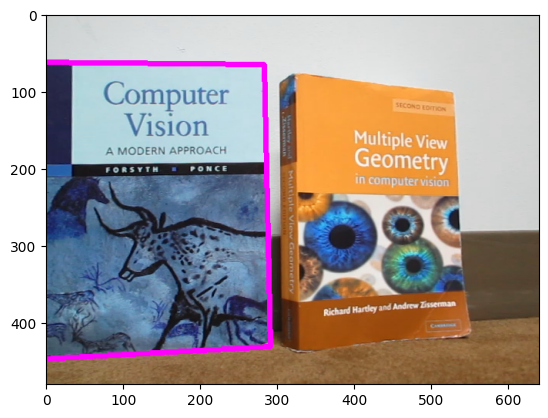

In [20]:

# get output video info
fps = int(book_vid.get(cv.CAP_PROP_FPS))
width = int(book_vid.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(book_vid.get(cv.CAP_PROP_FRAME_HEIGHT))

out = cv.VideoWriter('output_ar.mp4', cv.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

if not (ret and success):
    print("Error: Could not read first frames.")
    book_vid.release()
    vid.release()
    out.release()
    raise SystemExit

prev_book = book_first_frame
frame_idx = 1
pbar = tqdm(total=int(book_vid.get(cv.CAP_PROP_FRAME_COUNT)), desc="Rendering AR video")

while True:
    ret_book, curr_book = book_vid.read()
    ret_movie, movie_frame = vid.read()
    if not ret_book or not ret_movie:
        break  # finished one of the videos

    H, img_match, warped, mask, corner_positions = knn_brute_force(book_img, curr_book)

    movie_frame = remove_black_borders(movie_frame)
    # crop the movie frame to match book aspect
    cropped_movie = crop_movie(movie_frame, corner_positions)

    # overlay the movie frame on the book
    ar_frame = overlay(cropped_movie, curr_book, corner_positions)

    out.write(ar_frame)

    # update previous frame data
    prev_book = curr_book.copy()
    frame_idx += 1
    pbar.update(1)

pbar.close()
book_vid.release()
vid.release()
out.release()

print("AR video created successfully: output_ar.mp4")
